In [93]:
import numpy as np
from control.matlab import *
import matplotlib.pyplot as plt
import scipy.io 

In [94]:
zc = 0.6    # Hight of CoM
dt = 0.005  # Time step
t_preview = 2 # Preview time (Horizon)
Qe = 1e-4   # Preview control parameter
R = 1e-6    # Preview control parameter
# Qx set to 0 typically (not used)

# Foot position
footstep = [[0.0, 0.0, 0.0],
            [0.2, 0.06, 0.0], 
            [0.4, -0.06, 0.0],
            [0.6, 0.09, 0.0],
            [0.8, -0.03, 0.0],
            [1.3, 0.09, 0.0], 
            [1.7, -0.03, 0.0],
            [1.9, 0.09, 0.0],
            [2.0, -0.03, 0.0]]

t_step = 0.6 # time for each foot step
t_calc = t_step * len(footstep) - t_preview # How long to calculate for CoM


In [95]:
def get_preview_control_parameter(zc, dt, t_preview, Qe, R):
    g = 9.81
    A = np.matrix([[0, 1, 0],
                   [0, 0, 1],
                   [0, 0, 0]])
    B = np.matrix([[0],
                   [0],
                   [1]])
    C = np.matrix([[1, 0, -zc/g]])
    D = 0
    
    sys_c = ss(A, B, C, D)
    sys_d = c2d(sys_c, dt)
    [A_d, B_d, C_d, D_d] = ssdata(sys_d)

    C_d_dot_A_d = C_d*A_d

    C_d_dot_B_d = C_d*B_d

    A_tilde = np.matrix([[1, C_d_dot_A_d[0,0], C_d_dot_A_d[0,1], C_d_dot_A_d[0,2]],
                         [0, A_d[0,0], A_d[0,1], A_d[0,2]],
                         [0, A_d[1,0], A_d[1,1], A_d[1,2]],
                         [0, A_d[2,0], A_d[2,1], A_d[2,2]]])
    B_tilde = np.matrix([[C_d_dot_B_d[0,0]],
                         [B_d[0,0]],
                         [B_d[1,0]],
                         [B_d[2,0]]])
    C_tilde = np.matrix([[1, 0, 0, 0]])

    Q = np.matrix([[Qe, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])

    P, _, K  = dare(A_tilde, B_tilde, Q, R)

    Gi = K[0,0:1]
    Gx = K[0,1:]

    N = np.arange(0, t_preview, dt).reshape(1,-1)

    Gd = np.zeros(N.shape)

    Gd[0,0] = -Gi

    Ac_tilde = A_tilde - B_tilde * K

    I_tilde = np.matrix([[1],[0],[0],[0]])

    X_tilde = -Ac_tilde.T*P*I_tilde

    for i in range(1, N.shape[1]):
        Gd[0,i] = (R+B_tilde.T*P*B_tilde)**(-1)*B_tilde.T*X_tilde;
        X_tilde = Ac_tilde.T*X_tilde
        
    return np.array(A_d), np.array(B_d), np.array(C_d), np.array(Gi), np.array(Gx), Gd

In [96]:
A_d, B_d, C_d, Gi, Gx, Gd = get_preview_control_parameter(zc, dt, t_preview, Qe, R)

/var/folders/hx/7rb6ycp92kqgqpj6znytgxs40000gn/T/ipykernel_39600/3514314153.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Gd[0,0] = -Gi
/var/folders/hx/7rb6ycp92kqgqpj6znytgxs40000gn/T/ipykernel_39600/3514314153.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Gd[0,i] = (R+B_tilde.T*P*B_tilde)**(-1)*B_tilde.T*X_tilde;


In [97]:
print(f"{np.shape(Gd)}")

(1, 400)


In [98]:
def generate_zmp_trajectory(footstep, dt, t_step):
    n_step = len(footstep)
    zmp_x = []
    zmp_y = []
    k = 0
    for i in range(0, n_step * int(t_step/dt)):
        zmp_x.append(footstep[k][0])
        zmp_y.append(footstep[k][1])
        if i != 0 and i%int(t_step/dt) == 0:
            k += 1
    return zmp_x, zmp_y

def calc_preview_control(zmp_x, zmp_y, dt, t_preview, t_calc, A_d, B_d, C_d, Gi, Gx, Gd):
    # State vector
    x_x = np.array([[0],
                    [0],
                    [0]])
    x_y = np.array([[0],
                    [0],
                    [0]])
    com_x = []
    com_y = []

    for i in range(0, int(t_calc / dt)): # for each time step k, calculate u(k), i.e. CoM position
        # Calculate output y(k) = actual ZMP = p(k) = C_d*x(k)
        y_x = np.ndarray.item(C_d.dot(x_x))
        y_y = np.ndarray.item(C_d.dot(x_y))
        # e(k) = reference/target ZMP - actual ZMP
        e_x = zmp_x[i] - y_x
        e_y = zmp_y[i] - y_y

        preview_x = 0
        preview_y = 0
        n = 0
        for j in range(i, i+int(t_preview/dt)):
            preview_x += Gd[0, n] * zmp_x[j]
            preview_y += Gd[0, n] * zmp_y[j]
            n += 1

        u_x = np.ndarray.item(-Gi * e_x - Gx.dot(x_x) - preview_x)
        u_y = np.ndarray.item(-Gi * e_y - Gx.dot(x_y) - preview_y)
        
        x_x = A_d.dot(x_x) + B_d * u_x 
        x_y = A_d.dot(x_y) + B_d * u_y

        com_x.append(x_x[0,0])
        com_y.append(x_y[0,0])

    return com_x, com_y


i: 0, j: 0
i: 0, j: 1
i: 0, j: 2
i: 0, j: 3
i: 0, j: 4
i: 0, j: 5
i: 0, j: 6
i: 0, j: 7
i: 0, j: 8
i: 0, j: 9
i: 0, j: 10
i: 0, j: 11
i: 0, j: 12
i: 0, j: 13
i: 0, j: 14
i: 0, j: 15
i: 0, j: 16
i: 0, j: 17
i: 0, j: 18
i: 0, j: 19
i: 0, j: 20
i: 0, j: 21
i: 0, j: 22
i: 0, j: 23
i: 0, j: 24
i: 0, j: 25
i: 0, j: 26
i: 0, j: 27
i: 0, j: 28
i: 0, j: 29
i: 0, j: 30
i: 0, j: 31
i: 0, j: 32
i: 0, j: 33
i: 0, j: 34
i: 0, j: 35
i: 0, j: 36
i: 0, j: 37
i: 0, j: 38
i: 0, j: 39
i: 0, j: 40
i: 0, j: 41
i: 0, j: 42
i: 0, j: 43
i: 0, j: 44
i: 0, j: 45
i: 0, j: 46
i: 0, j: 47
i: 0, j: 48
i: 0, j: 49
i: 0, j: 50
i: 0, j: 51
i: 0, j: 52
i: 0, j: 53
i: 0, j: 54
i: 0, j: 55
i: 0, j: 56
i: 0, j: 57
i: 0, j: 58
i: 0, j: 59
i: 0, j: 60
i: 0, j: 61
i: 0, j: 62
i: 0, j: 63
i: 0, j: 64
i: 0, j: 65
i: 0, j: 66
i: 0, j: 67
i: 0, j: 68
i: 0, j: 69
i: 0, j: 70
i: 0, j: 71
i: 0, j: 72
i: 0, j: 73
i: 0, j: 74
i: 0, j: 75
i: 0, j: 76
i: 0, j: 77
i: 0, j: 78
i: 0, j: 79
i: 0, j: 80
i: 0, j: 81
i: 0, j: 82
i: 0, j: 83
i:

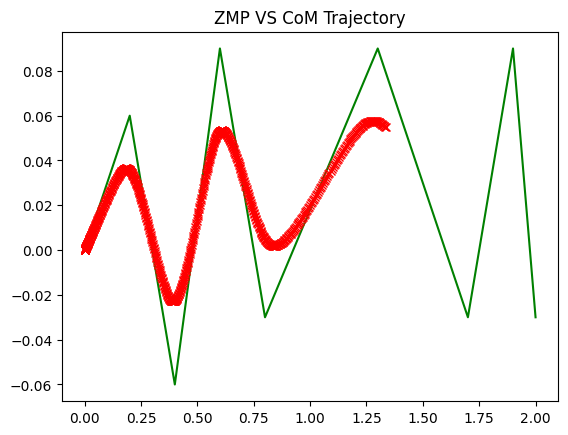

In [99]:

zmp_x, zmp_y = generate_zmp_trajectory(footstep, dt, t_step)
com_x, com_y = calc_preview_control(zmp_x, zmp_y, dt, t_preview, t_calc, A_d, B_d, C_d, Gi, Gx, Gd)
plt.title("ZMP VS CoM Trajectory")
plt.plot(zmp_x, zmp_y, color='green')
plt.plot(com_x, com_y, 'x', color='red')
plt.show()

In [101]:
print(f"{len(zmp_x)}")
print(f"{len(zmp_y)}")
print(f"{t_calc}")

1080
